In [1]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
sales_data = pd.read_csv("./示例数据/order_train1.csv")
test  = pd.read_csv("./示例数据/predict_sku1.csv")

In [3]:
sales_data.head()

order_date  sales_region_code  item_code  first_cate_code  second_cate_code  \
0   2015/9/1                104      22069              307               403   
1   2015/9/1                104      20028              301               405   
2   2015/9/2                104      21183              307               403   
3   2015/9/2                104      20448              308               404   
4   2015/9/2                104      21565              307               403   

  sales_chan_name  item_price  ord_qty  
0         offline      1114.0       19  
1         offline      1012.0       12  
2          online       428.0      109  
3          online       962.0        3  
4         offline      1400.0        3

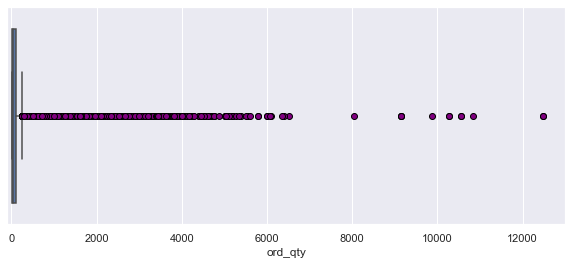

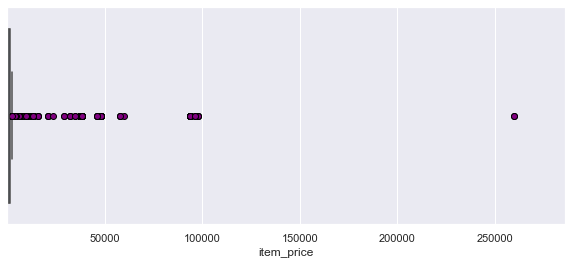

In [4]:
# 销售量
plt.figure(figsize=(10,4))
plt.xlim(-100, 13000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_data.ord_qty, flierprops=flierprops)
plt.savefig("./图片/异常值1.png",dpi=200)
# 价格
plt.figure(figsize=(10,4))
plt.xlim(sales_data.item_price.min(), sales_data.item_price.max()*1.1)
sns.boxplot(x=sales_data.item_price, flierprops=flierprops)
plt.savefig("./图片/异常值2.png",dpi=200)


In [5]:
sales_data = sales_data[(sales_data.item_price < 30000 )& (sales_data.ord_qty < 4000)]

In [6]:
sales_data["order_date"]=sales_data["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [7]:
# 生成一列月份编号
sales_data["month"] = sales_data.order_date.dt.month
sales_data["year"] = sales_data.order_date.dt.year
sales_data["date_block_num"] = (sales_data["year"]-sales_data["year"].min())*12+sales_data["month"]-9 # 减8是因为第一个月是9月份

# 输出结果
del sales_data["month"],sales_data["year"]

In [8]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num","sales_region_code", "item_code"]
for i in range(40):
    sales = sales_data[sales_data.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.sales_region_code.unique(), sales.item_code.unique()) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols ) # 堆叠
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["sales_region_code"] = matrix["sales_region_code"].astype(np.int8)
matrix["item_code"] = matrix["item_code"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts 

0.20760107040405273

In [9]:
ts = time.time()
group = sales_data.groupby( ["date_block_num", "sales_region_code", "item_code"] ).agg( {"ord_qty": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True) # 这一步重置索引，直接把层级索引转换为列
matrix = pd.merge( matrix, group, on = cols, how = "left" ) # 转换后，二者就可以merge了
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16) # 填补缺失值
time.time() - ts

0.14906787872314453

In [10]:
# 给matrix补充上类别属性
map_cate_df = sales_data[["first_cate_code","second_cate_code","item_code"]].drop_duplicates()
map_cate_df.head()
matrix = pd.merge(matrix, map_cate_df, on = ["item_code"], how = "left")
matrix["first_cate_code"] = matrix["first_cate_code"]
matrix["second_cate_code"] = matrix["second_cate_code"]

In [11]:
matrix

date_block_num  sales_region_code  item_code  item_cnt_month  \
0                    0                101      20003             0.0   
1                    0                101      20006             0.0   
2                    0                101      20007          3092.0   
3                    0                101      20008           308.0   
4                    0                101      20009           260.0   
...                ...                ...        ...             ...   
107691              39                105      22080            16.0   
107692              39                105      22081             7.0   
107693              39                105      22082             0.0   
107694              39                105      22083          1124.0   
107695              39                105      22084             0.0   

        first_cate_code  second_cate_code  
0                   301               405  
1                   307               403  
2                   305               412  
3                   303               401  
4                   306               407  
...                 ...               ...  
107691              306               407  
107692              303               401  
107693              305               412  
107694              303               401  
107695              302               408  

[107696 rows x 6 columns]

In [12]:
matrix.to_excel("月度合成数据.xlsx")

In [13]:
# 选取某个商品的月度销量并画线
item_code = 20003
se = matrix[matrix["item_code"]==item_code]
print(f"其在那哪些地区分布{se.sales_region_code.unique()}")



其在那哪些地区分布[101 102 103 104 105]


In [14]:
# se2 = se[se["sales_region_code"]==105]["date_block_num","item_cnt_month"].reset_index(drop=True)
# se2.plot()

In [15]:
def item_plot(item_code,region="all"):
    """
    查看某一商品，在某一地区的月平均销量和月销量
    默认是全部地区，可以指定101/102/../105
    输入商品代码和地区可查看
    """
    item_sales_data = sales_data[sales_data["item_code"]==item_code]
    if region == "all":
        gp_month_mean = item_sales_data.groupby(['date_block_num'], as_index=False)['ord_qty'].mean()
        gp_month_sum = item_sales_data.groupby(['date_block_num'], as_index=False)['ord_qty'].sum()
    else:
        item_sales_data_ = item_sales_data[item_sales_data["sales_region_code"]==int(region)]
        gp_month_mean = item_sales_data_.groupby(['date_block_num'], as_index=False)['ord_qty'].mean()
        gp_month_sum = item_sales_data_.groupby(['date_block_num'], as_index=False)['ord_qty'].sum()
    f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
    sns.lineplot(x="date_block_num", y="ord_qty", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
    sns.lineplot(x="date_block_num", y="ord_qty", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
    plt.show()
    return ;

In [16]:
# # Grouping data for EDA.
# gp_month_mean = item_sales_data.groupby(['date_block_num'], as_index=False)['ord_qty'].mean()
# gp_month_sum = item_sales_data.groupby(['date_block_num'], as_index=False)['ord_qty'].sum()

# gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
# gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
# gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
# gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

In [17]:
# sales_data.item_code.unique()

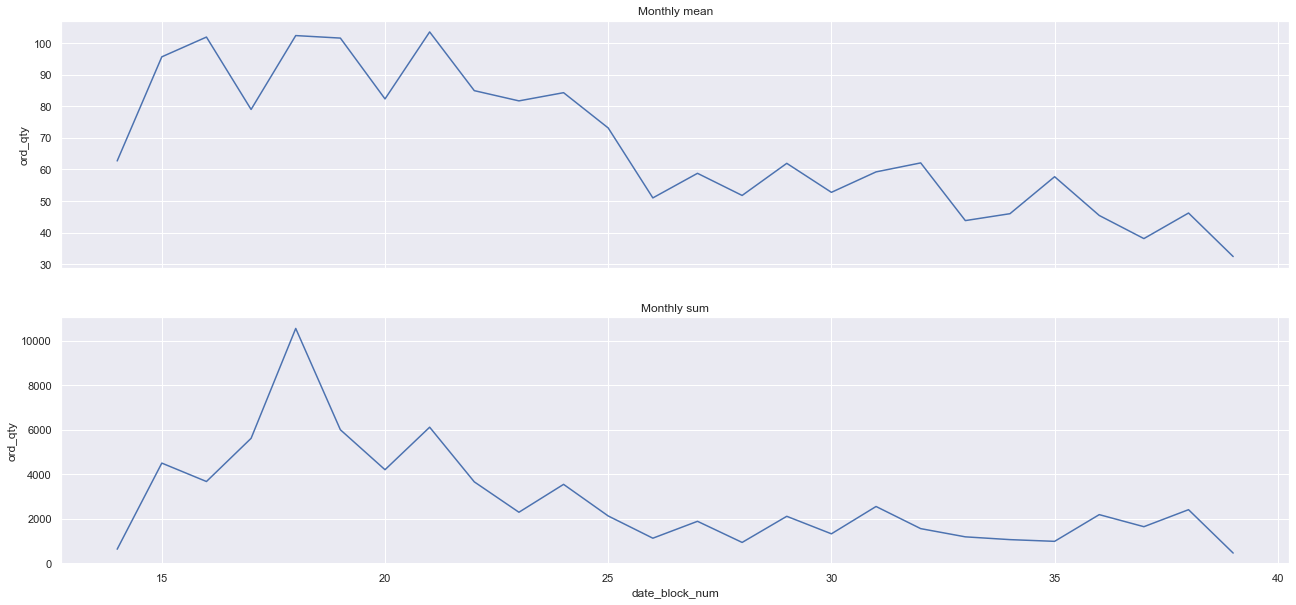

In [18]:
# item_plot(20016,"105")
item_plot(20016) # 20016商品全部地区

# 查看天销量

In [19]:
sales_data

order_date  sales_region_code  item_code  first_cate_code  \
0      2015-09-01                104      22069              307   
1      2015-09-01                104      20028              301   
2      2015-09-02                104      21183              307   
3      2015-09-02                104      20448              308   
4      2015-09-02                104      21565              307   
...           ...                ...        ...              ...   
597689 2018-12-20                102      20994              302   
597690 2018-12-20                102      21875              302   
597691 2018-12-20                102      20215              302   
597692 2018-12-20                102      20195              302   
597693 2018-12-20                102      20321              302   

        second_cate_code sales_chan_name  item_price  ord_qty  date_block_num  
0                    403         offline      1114.0       19               0  
1                    405         offline      1012.0       12               0  
2                    403          online       428.0      109               0  
3                    404          online       962.0        3               0  
4                    403         offline      1400.0        3               0  
...                  ...             ...         ...      ...             ...  
597689               408         offline       843.0       59              39  
597690               408         offline       762.0      502              39  
597691               408         offline      2013.0      106              39  
597692               408         offline      2120.0      187              39  
597693               408         offline      1244.0      205              39  

[597522 rows x 9 columns]

In [20]:
item_list = sales_data["item_code"].unique()
item_list

array([22069, 20028, 21183, ..., 21110, 20551, 21320])

In [21]:
import pandas as pd

# 假设您有一个名为sales的字典，其中包含多个Series
sales = {
    'Product A': pd.Series(data=[10, 0, 0, 5], 
                           index=['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04']),
    'Product B': pd.Series(data=[2, 3, 0], 
                           index=['2017-03-05', '2017-03-06', '2017-03-08'])
}

# 将每个Series重新索引为完整的日期范围
date_range = pd.date_range(start='2015-09-01', end='2018-12-20', freq='D')
sales_reindexed = {name: series.reindex(date_range, fill_value=0) for name, series in sales.items()}

# 打印结果
for name, series in sales_reindexed.items():
    print(f"Product: {name}")
    print(series)


Product: Product A
2015-09-01    0
2015-09-02    0
2015-09-03    0
2015-09-04    0
2015-09-05    0
             ..
2018-12-16    0
2018-12-17    0
2018-12-18    0
2018-12-19    0
2018-12-20    0
Freq: D, Length: 1207, dtype: int64
Product: Product B
2015-09-01    0
2015-09-02    0
2015-09-03    0
2015-09-04    0
2015-09-05    0
             ..
2018-12-16    0
2018-12-17    0
2018-12-18    0
2018-12-19    0
2018-12-20    0
Freq: D, Length: 1207, dtype: int64


In [22]:
date_range = pd.date_range(start='2015-09-01', end='2018-12-20', freq='D')
sales_reindexed = series.reindex(date_range, fill_value=0)
fig = plt.figure(figsize=(20, 6))


<Figure size 1440x432 with 0 Axes>

<ipython-input-23-512f3b12d680>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


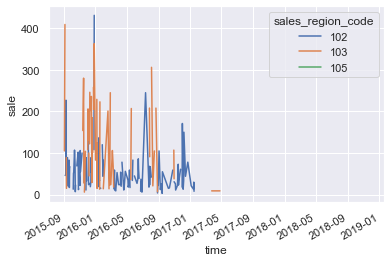

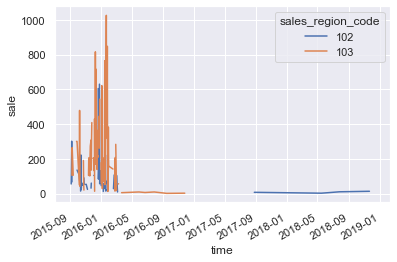

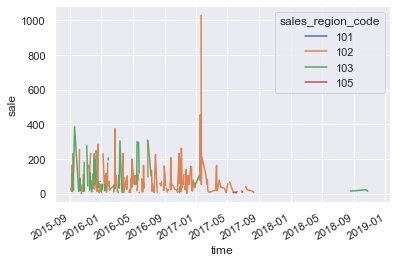

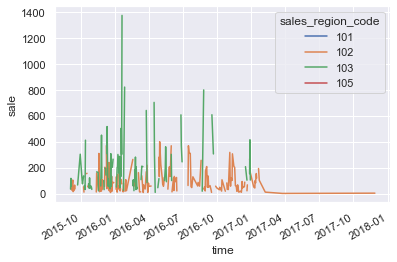

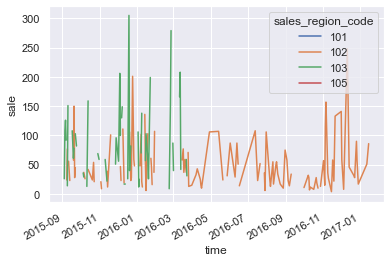

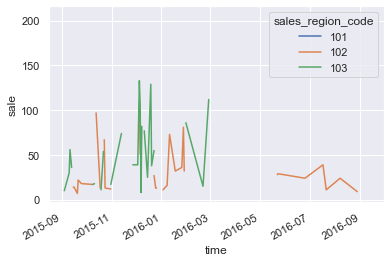

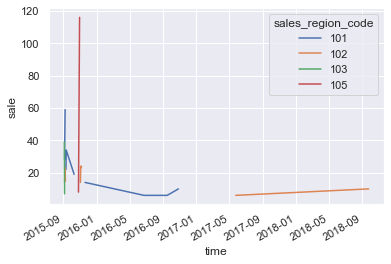

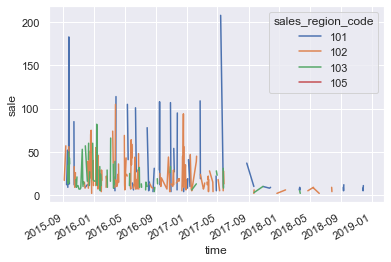

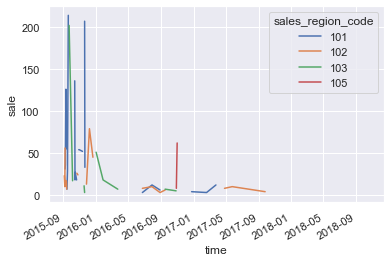

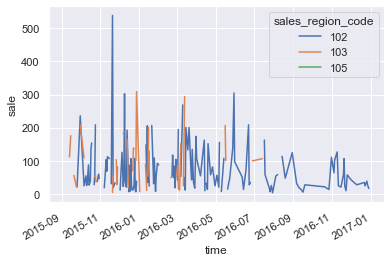

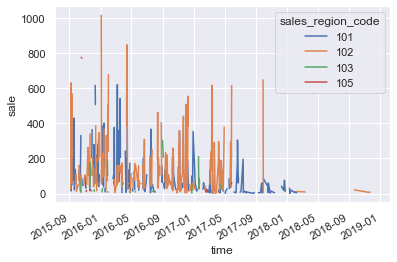

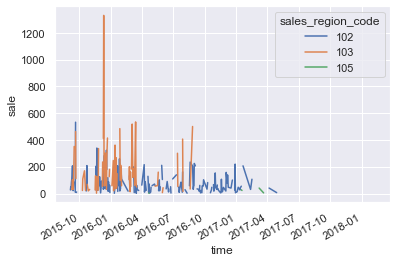

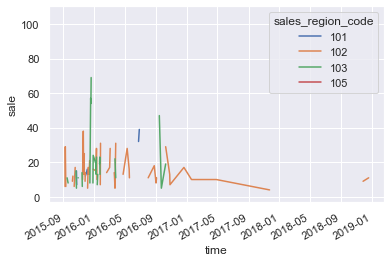

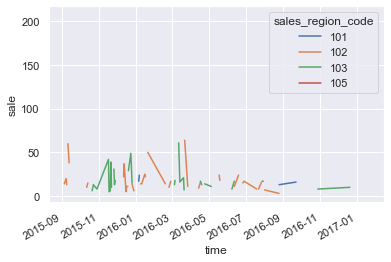

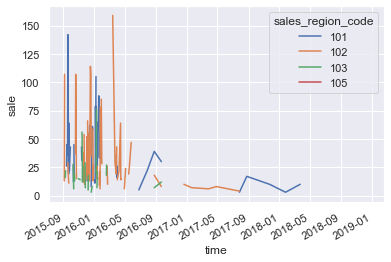

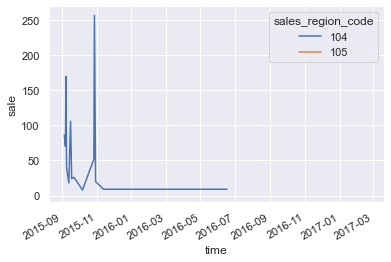

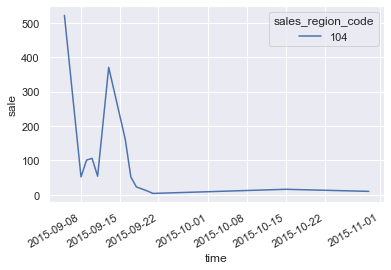

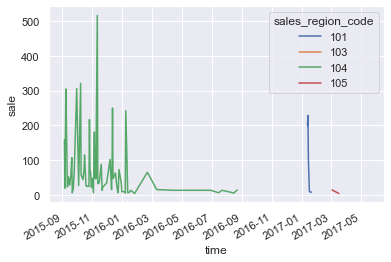

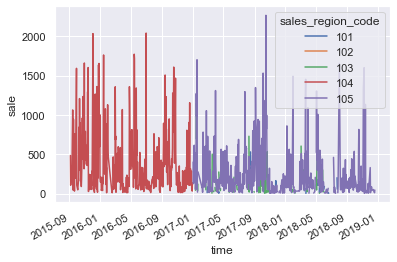

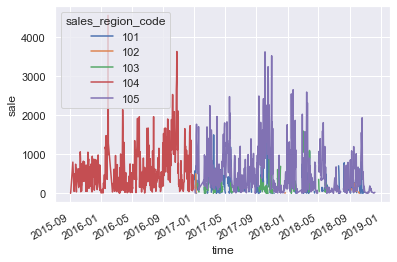

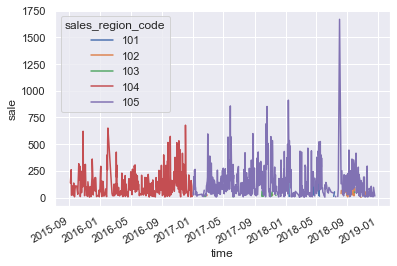

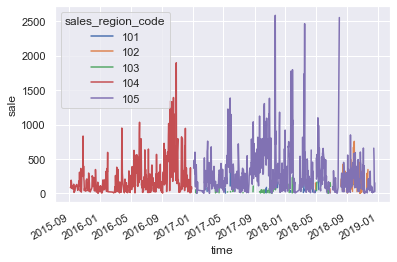

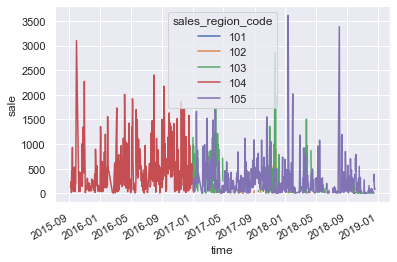

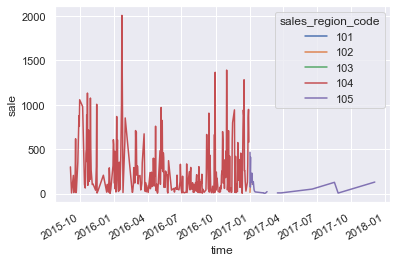

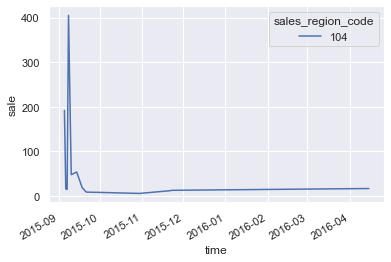

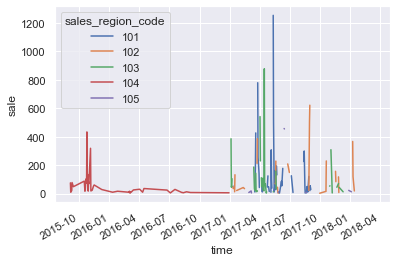

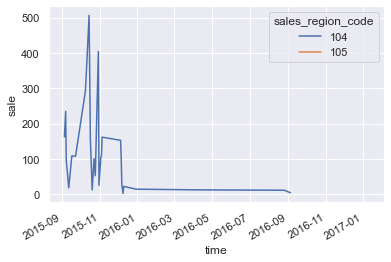

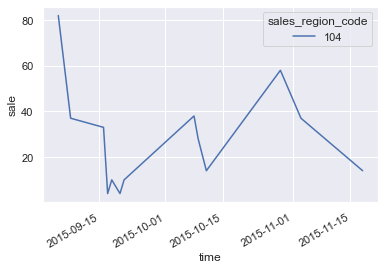

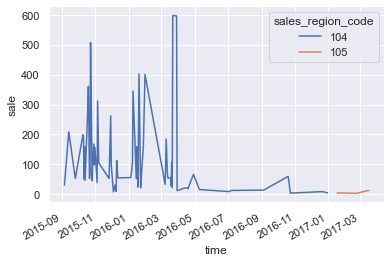

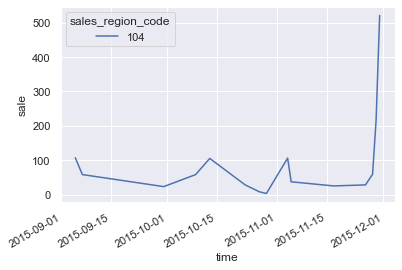

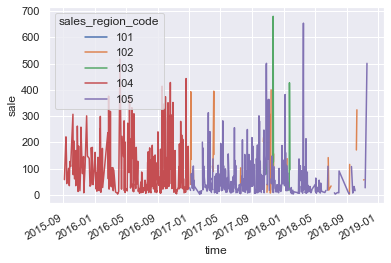

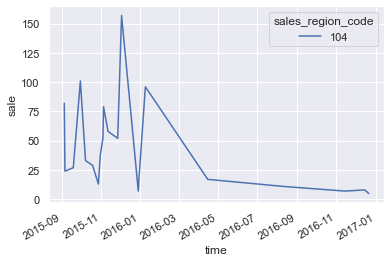

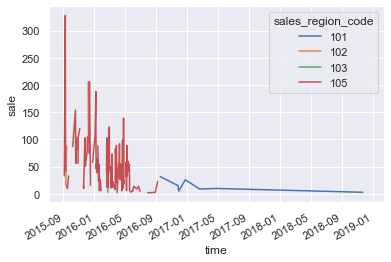

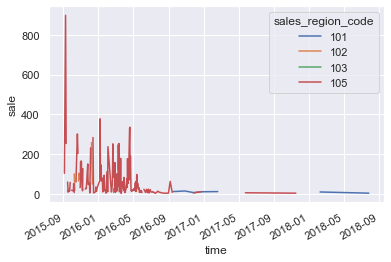

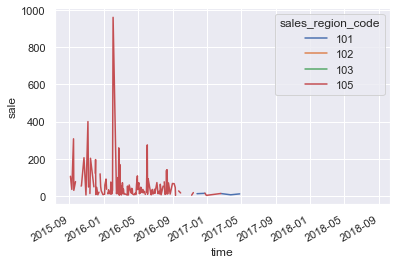

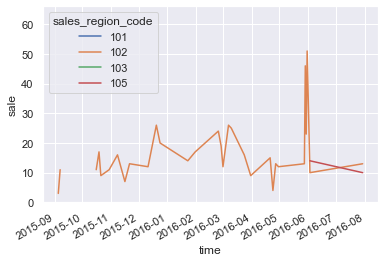

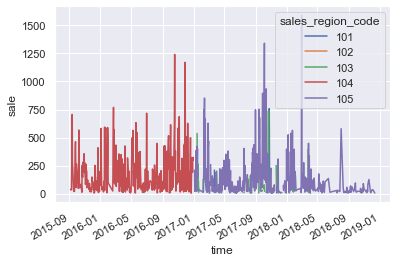

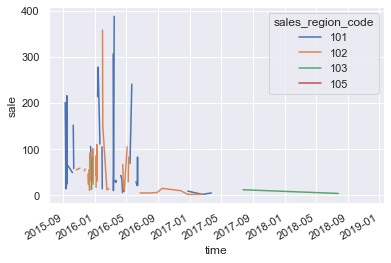

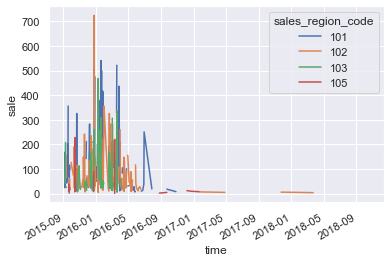

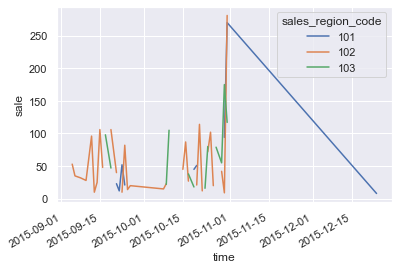

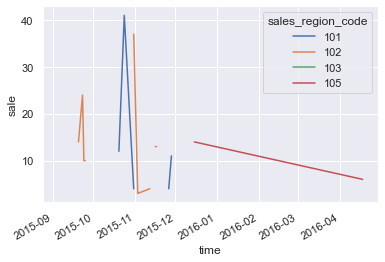

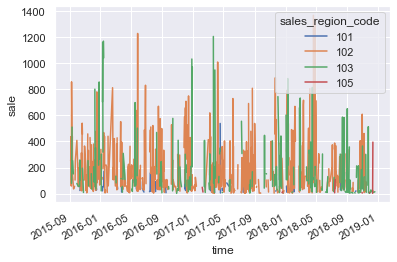

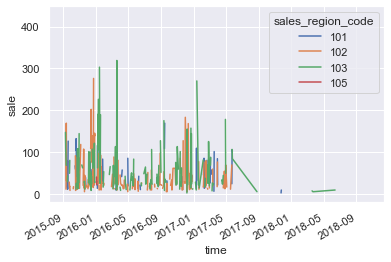

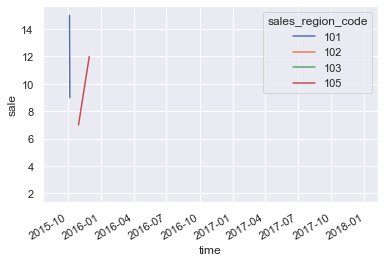

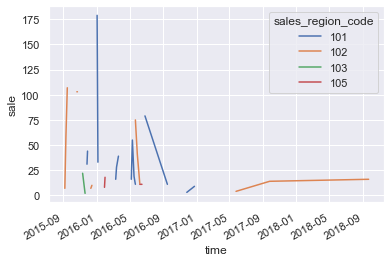

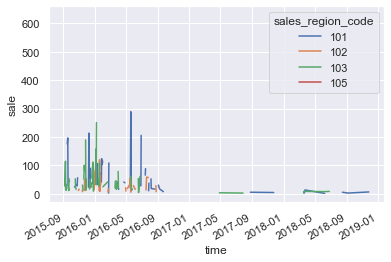

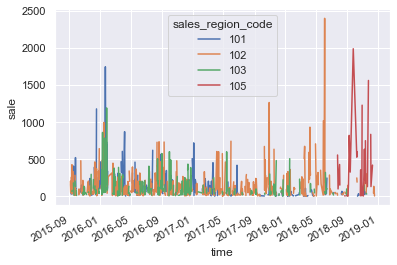

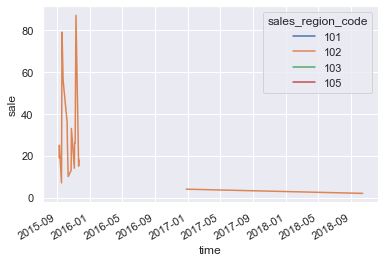

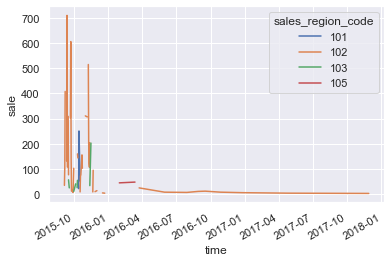

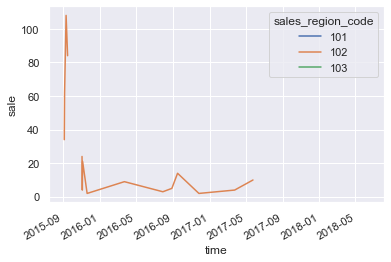

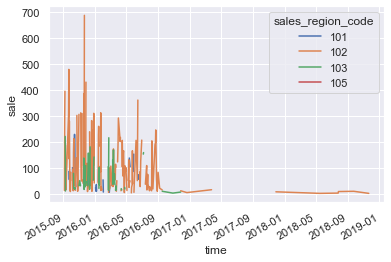

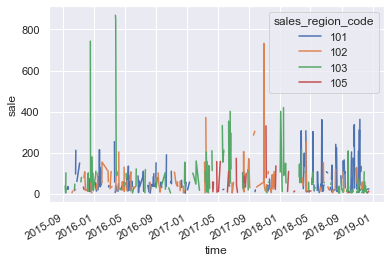

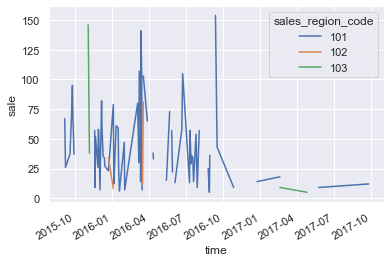

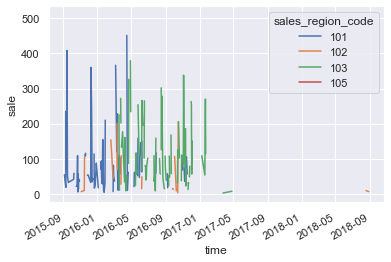

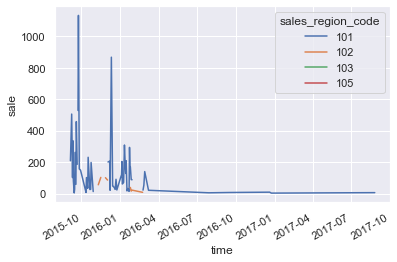

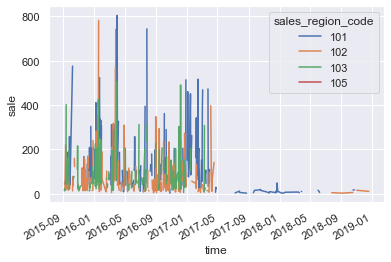

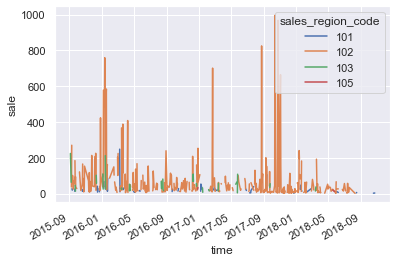

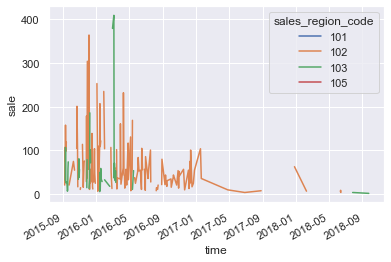

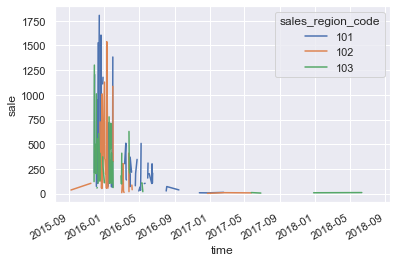

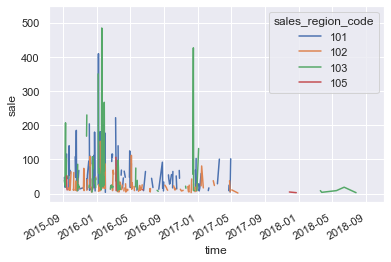

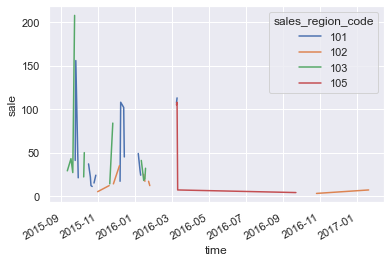

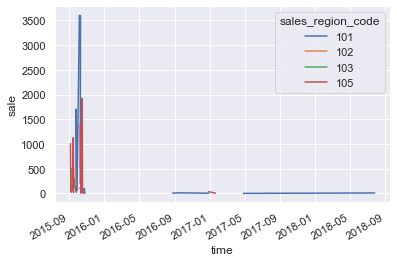

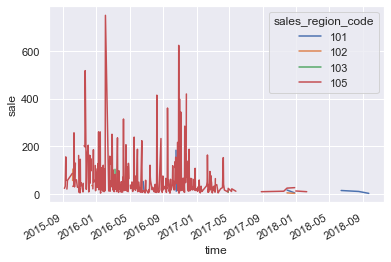

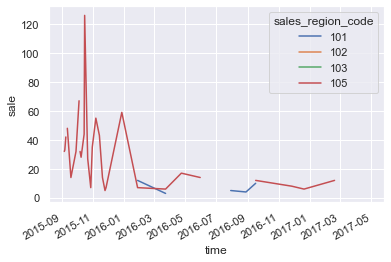

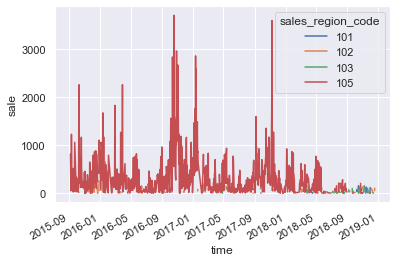

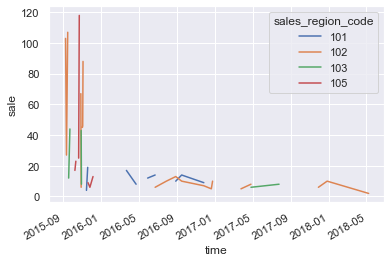

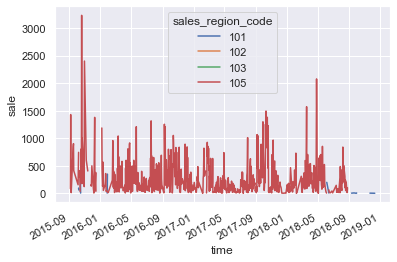

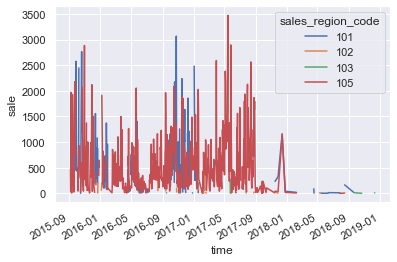

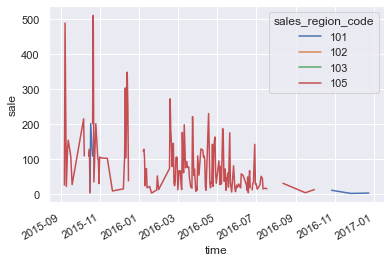

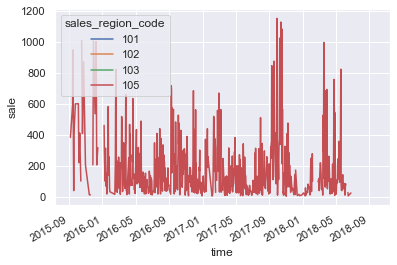

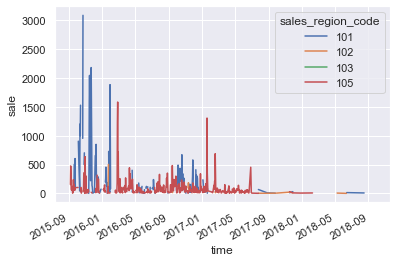

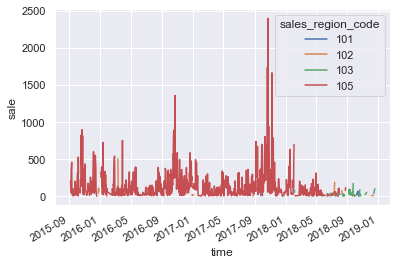

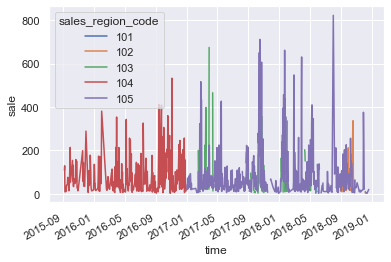

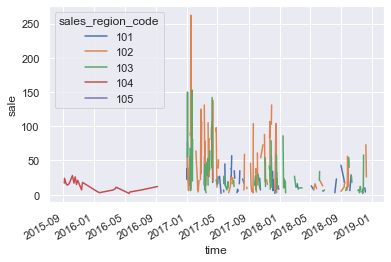

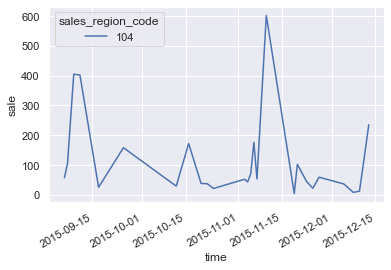

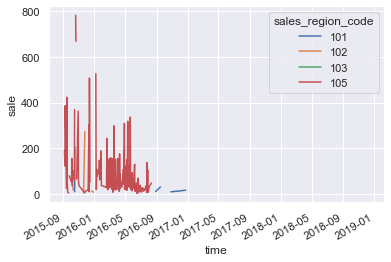

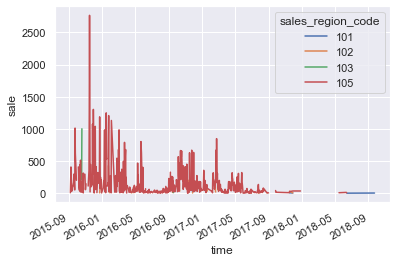

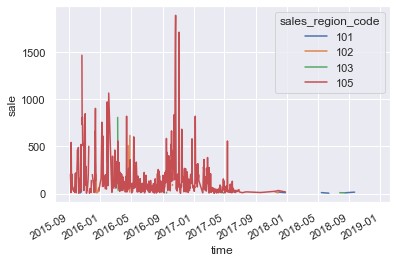

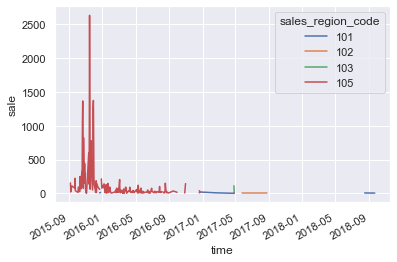

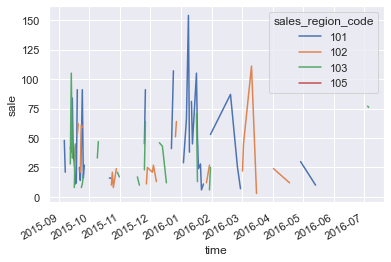

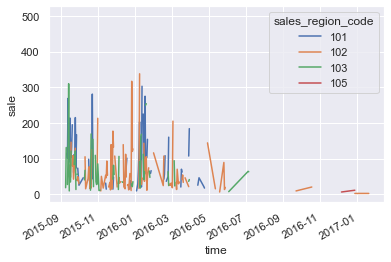

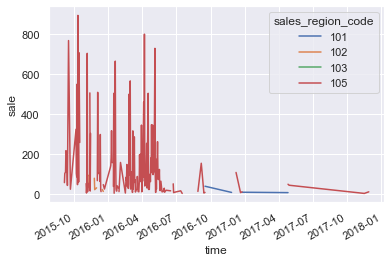

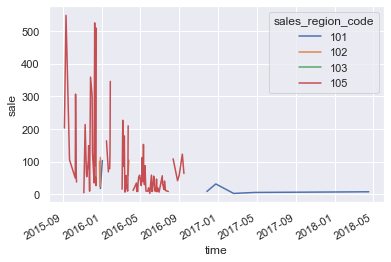

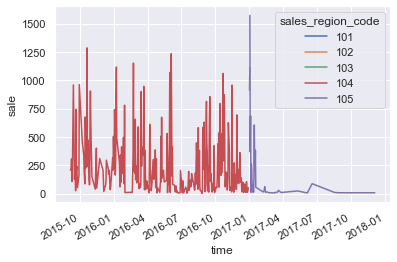

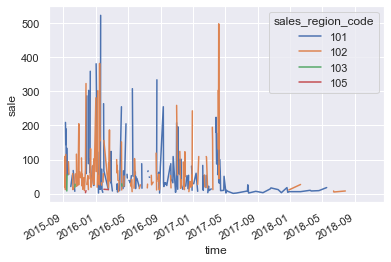

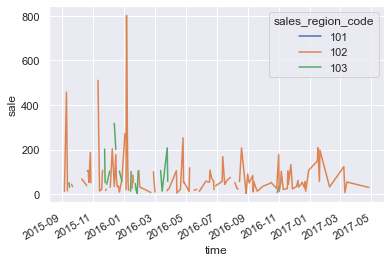

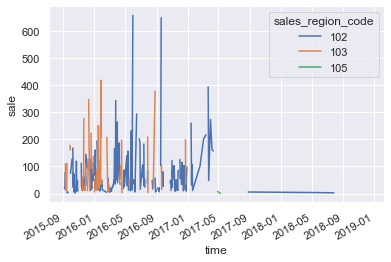

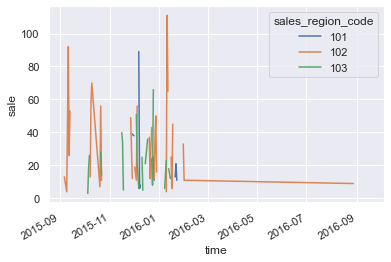

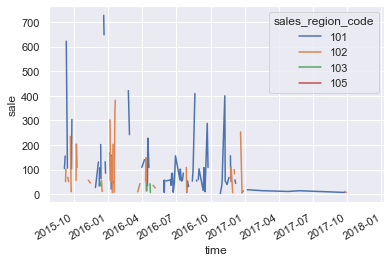

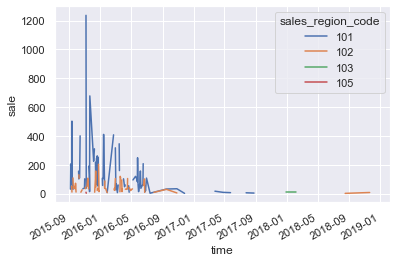

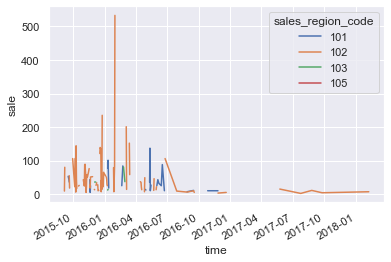

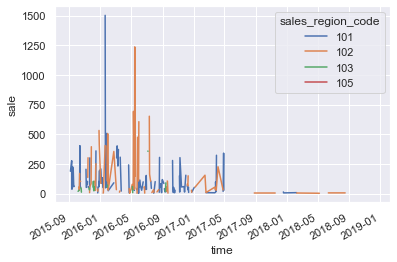

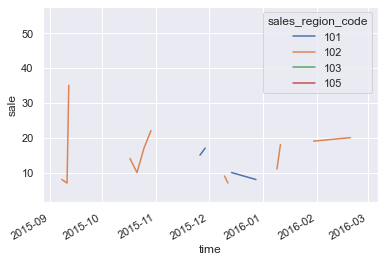

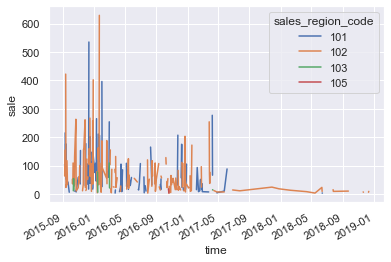

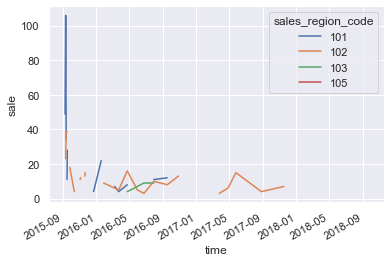

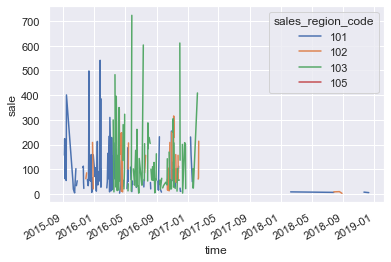

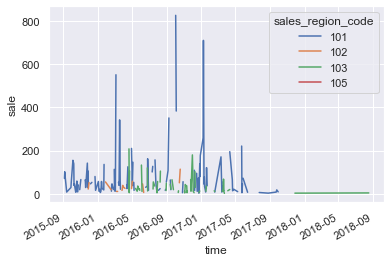

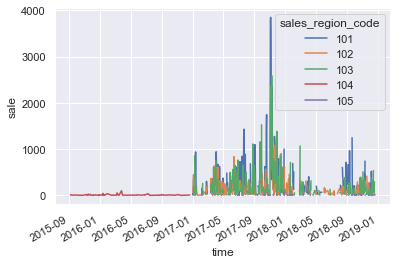

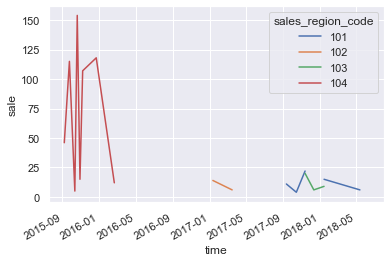

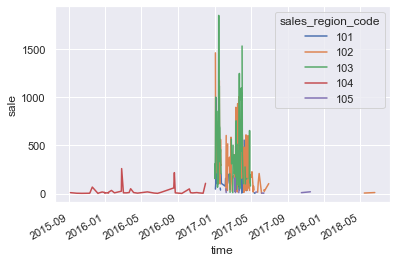

In [23]:
# 分析商品，在各个地区的销售情况
for item in item_list[100:200]:
    item_df = sales_data[sales_data["item_code"]==item]
    sales_by_region = item_df.groupby(['sales_region_code', 'order_date'])['ord_qty'].sum().unstack(level=0)
#     print(item)

    # 绘制折线图
    fig, ax = plt.subplots()
    sales_by_region.plot(ax=ax)
    ax.set_xlabel('time')
    ax.set_ylabel('sale')
#     plt.show()




order_date
2015-09-01    12
2015-09-02    11
2015-09-13     8
2015-09-15    10
2015-09-25     4
2017-03-17     5
Name: ord_qty, dtype: int64
20028


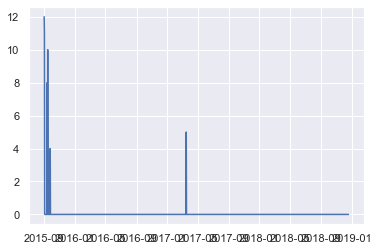

In [24]:

for item in item_list[1:2]:
    item_df = sales_data[sales_data["item_code"]==item][["order_date","ord_qty"]]
    series = item_df.set_index('order_date')['ord_qty'].squeeze()
    print(series)
    new_series = series+sales_reindexed
    new_series.fillna(0, inplace=True)
    print(item)
    plt.plot(new_series.index,new_series.values)
#     plt.show()

    


In [25]:
# sales_reindexed = series.reindex(date_range, fill_value=0) 
# sales_reindexed

# 第一问


价格与需求量关系

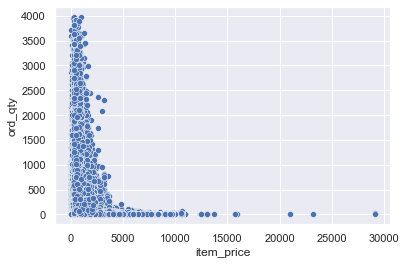

In [26]:
# 绘制价格与需求量的散点图
sns.scatterplot(x='item_price', y='ord_qty', data=sales_data)
plt.savefig("./图片/价格需求.png",dpi=200)

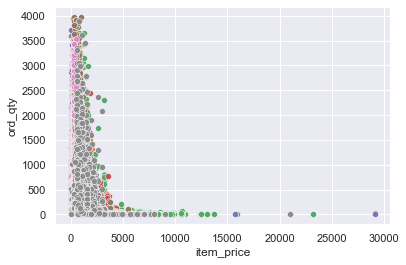

In [27]:
# 不同大类
for code in [301, 302, 303,304, 305,306,307,308]:
    m = sales_data[sales_data["first_cate_code"]==code]

    sns.scatterplot(x='item_price', y='ord_qty', data=m)

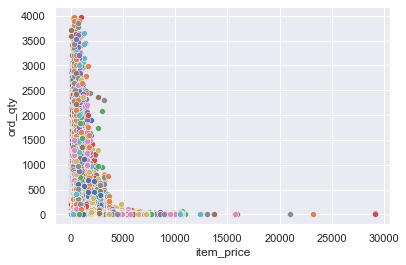

In [28]:
for item in item_list:
    m = sales_data[sales_data["item_code"]==item]
#     print(item)
    sns.scatterplot(x='item_price', y='ord_qty', data=m)
#     plt.scatter(m["item_price"],m["ord_qty"])
#     plt.show()

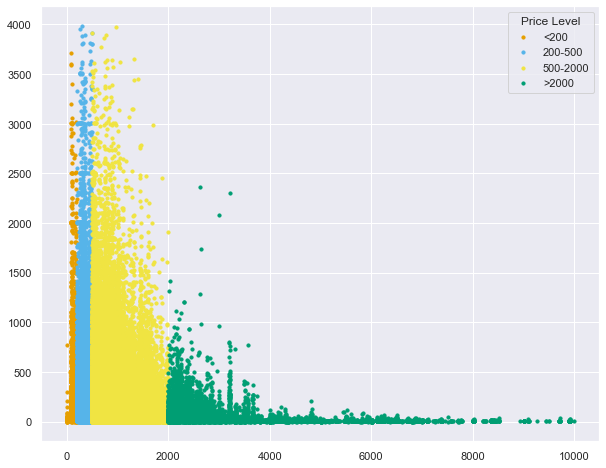

In [29]:
# 分价格区间
import pandas as pd
import matplotlib.pyplot as plt
data = sales_data
# 将价格划分为四类
bins = [0, 200, 500, 2000, 10000]
labels = ["<200", "200-500", "500-2000", ">2000"]
data["price_level"] = pd.cut(data["item_price"], bins=bins, labels=labels)

# 计算每个价格段的平均需求量
grouped = data.groupby("price_level")
agg_result = grouped["ord_qty"].agg(["mean"])

# 绘制散点图
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["#E69F00", "#56B4E9", "#F0E442", "#009E73"]
for i, level in enumerate(labels):
    x = data[data["price_level"] == level]["item_price"]
    y = data[data["price_level"] == level]["ord_qty"]
    ax.scatter(x, y, s=10, color=colors[i], label=level)
# ax.set_xlabel("价格")
# ax.set_ylabel("销量")
# ax.set_title("")
ax.legend(title="Price Level")
plt.savefig("./图片/价格需求2.png",dpi=200)

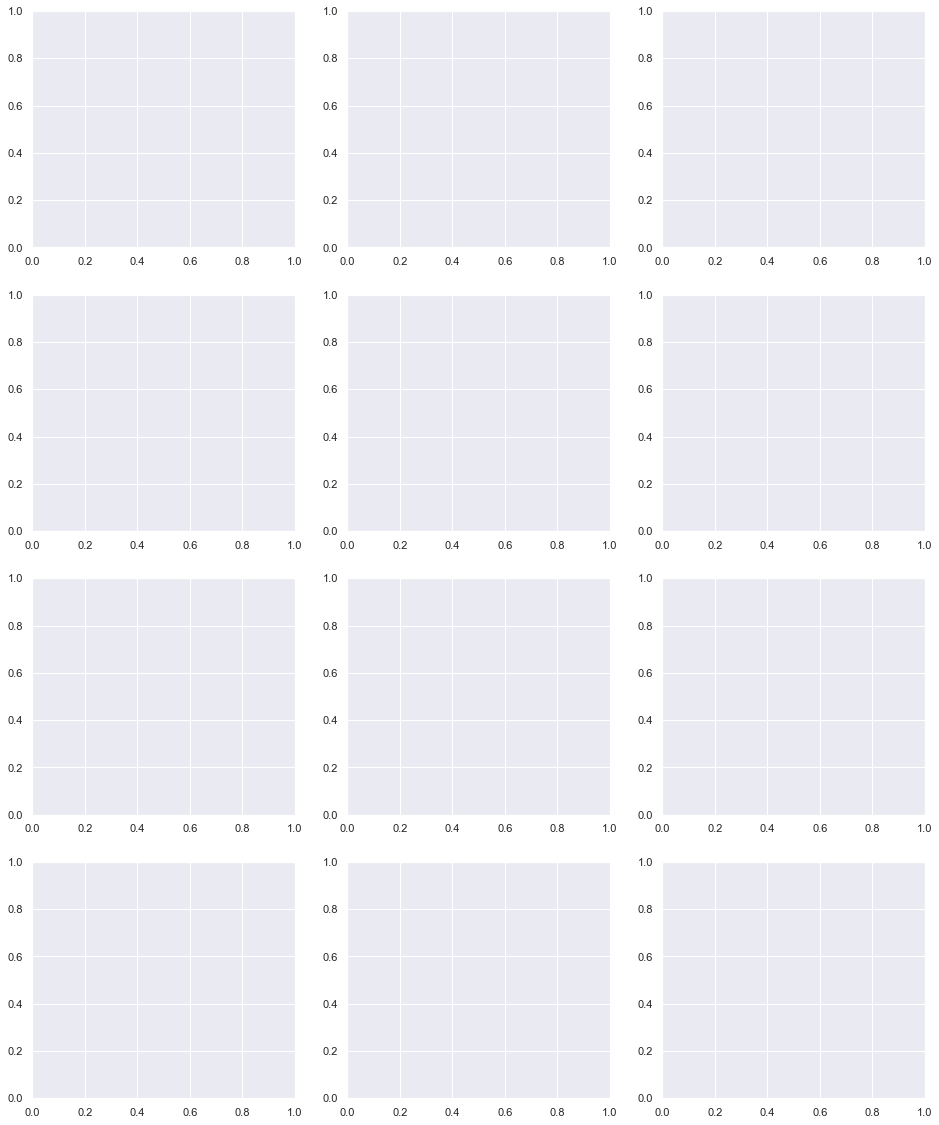

In [30]:
# 数据预处理，将价格分为四类
data['price_category'] = pd.cut(data['item_price'], bins=[0, 200, 500, 2000, 10000], labels=['0-200', '200-500', '500-2000', '2000-10000'])

# 每个小类分别绘制散点图
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# 设置字体
plt.rcParams['font.family'] = 'SimHei'

# 循环绘制
for i, code in enumerate([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    sub_data = data[data['second_cate_code']==code]
#     print(sub_data.columns)

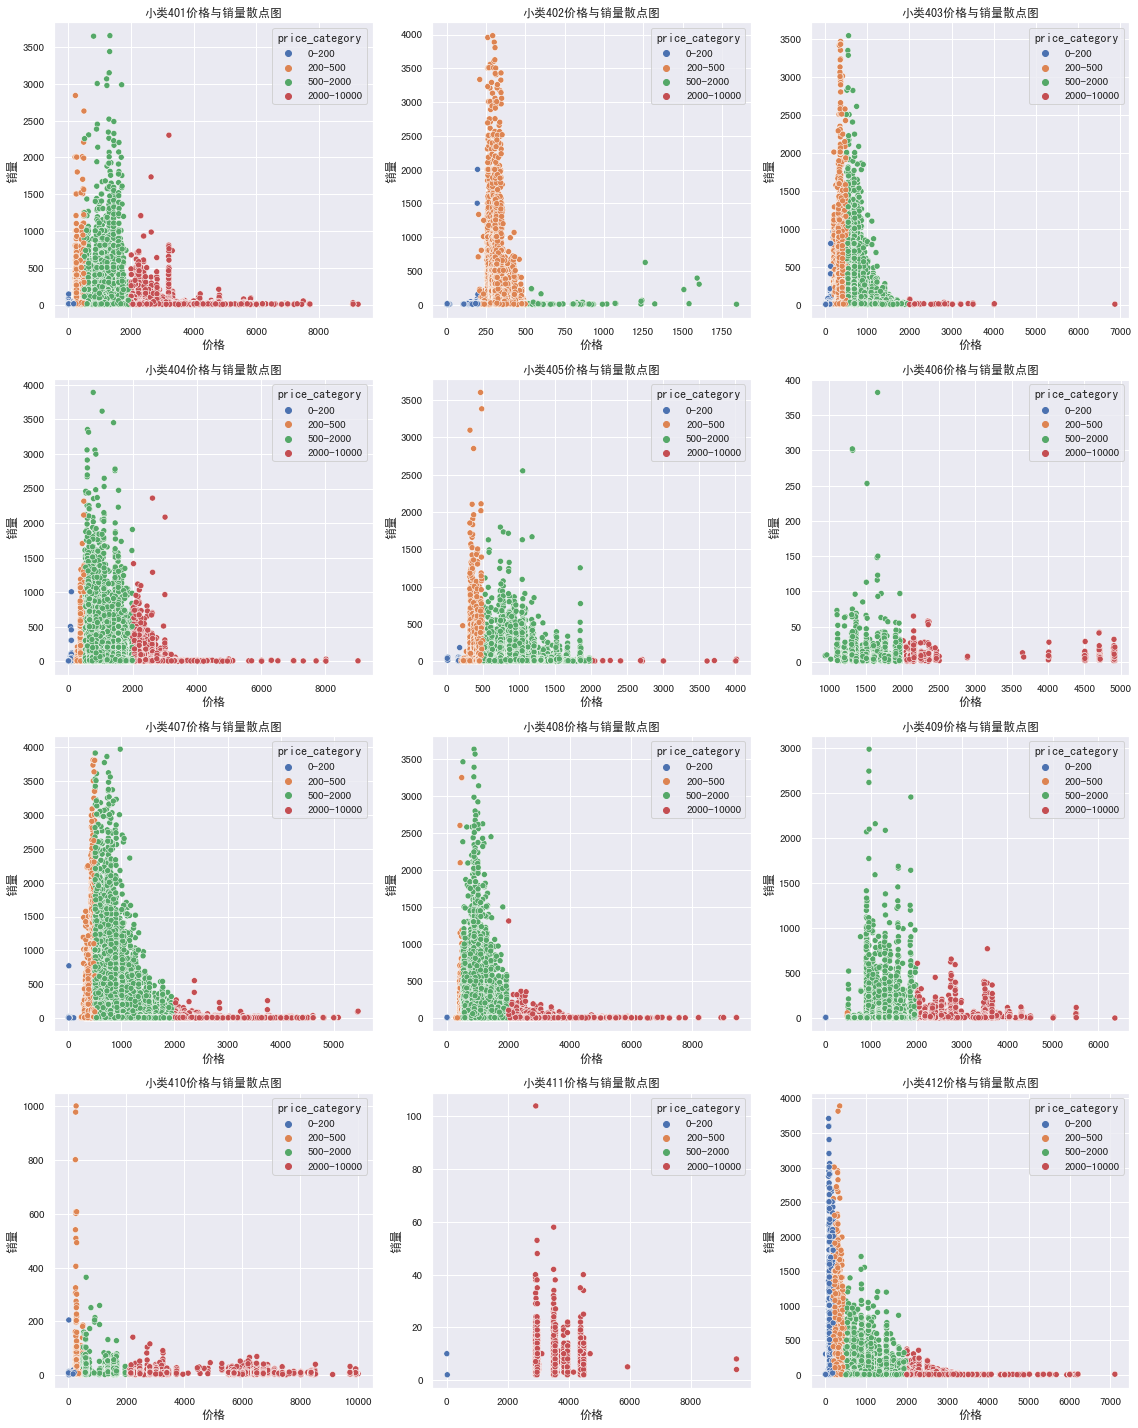

In [31]:
# 数据预处理，将价格分为四类
data['price_category'] = pd.cut(data['item_price'], bins=[0, 200, 500, 2000, 10000], labels=['0-200', '200-500', '500-2000', '2000-10000'])

# 每个小类分别绘制散点图
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

# 设置字体
plt.rcParams['font.family'] = 'SimHei'

# 循环绘制
for i, code in enumerate([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    sub_data = data[data['second_cate_code']==code]
    sns.scatterplot(x='item_price', y='ord_qty', hue='price_category', data=sub_data, ax=ax)
    ax.set_title(f"小类{code}价格与销量散点图")
    ax.set_xlabel("价格")
    ax.set_ylabel("销量")

# 调整布局
plt.tight_layout()

# 展示图像
plt.show()

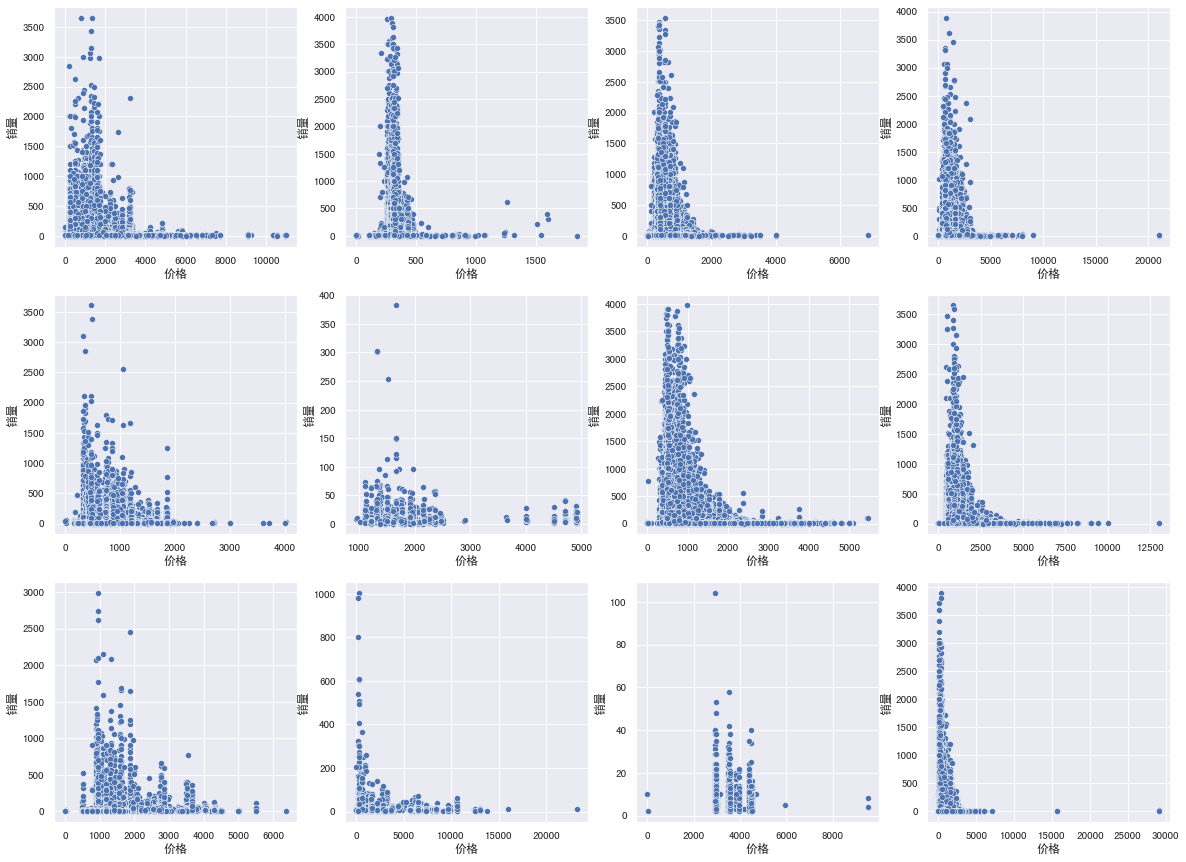

In [32]:
# 按二级分类进行分组
groups = data.groupby('second_cate_code')

# 创建一个大图，用于展示所有小图
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# 遍历每个二级分类，绘制相应的小图
for idx, (second_cate_code, group) in enumerate(groups):
    row = idx // 4
    col = idx % 4
    ax = axes[row, col]
    
    # 绘制散点图
    sns.scatterplot(data=group, x='item_price', y='ord_qty', ax=ax)
#      ax.set_title(f"小类{code}价格与销量散点图")
    ax.set_xlabel("价格")
    ax.set_ylabel("销量")

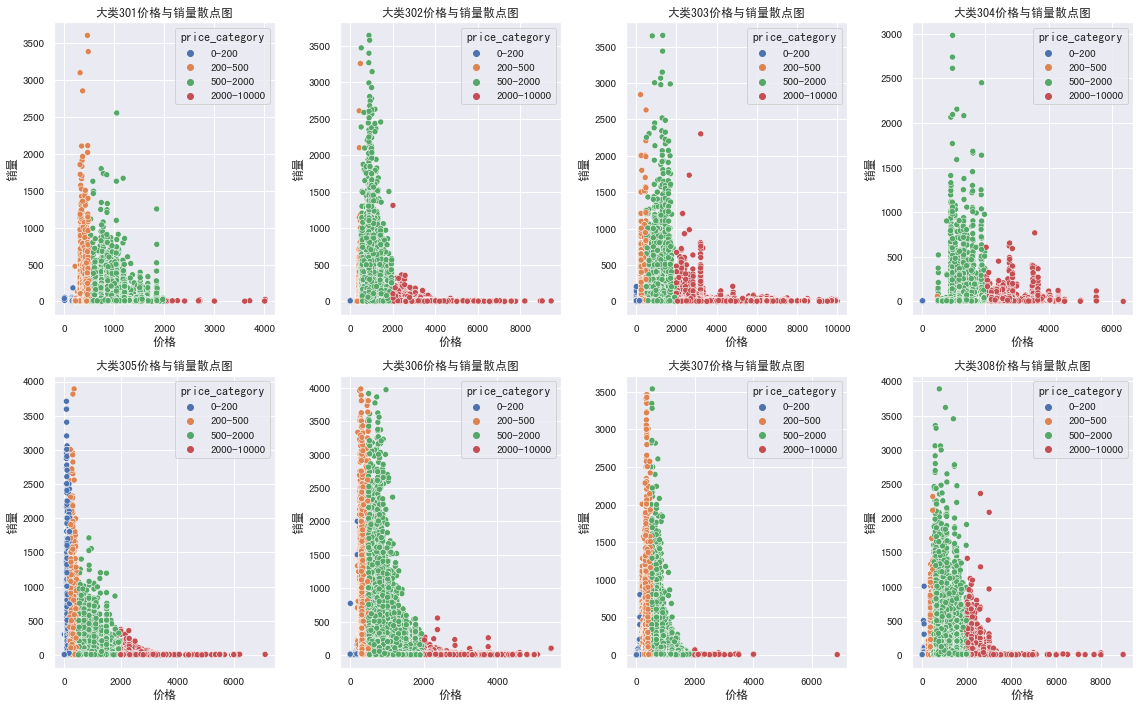

In [33]:
# 数据预处理，将价格分为四类
data['price_category'] = pd.cut(data['item_price'], bins=[0, 200, 500, 2000, 10000], labels=['0-200', '200-500', '500-2000', '2000-10000'])

# 每个大类分别绘制散点图
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

# 设置字体
plt.rcParams['font.family'] = 'SimHei'

# 循环绘制
for i, code in enumerate([301, 302, 303,304, 305,306,307,308]):
    row = i // 4
    col = i % 4
    ax = axs[row][col]
    sub_data = data[data['first_cate_code']==code]
    sns.scatterplot(x='item_price', y='ord_qty', hue='price_category', data=sub_data, ax=ax)
    ax.set_title(f"大类{code}价格与销量散点图")
    ax.set_xlabel("价格")
    ax.set_ylabel("销量")

# 调整布局
plt.tight_layout()

# 展示图像
plt.show()

地区和需求量关系

In [34]:
df = sales_data[sales_data["sales_region_code"]!=104]

In [35]:
df = sales_data

In [36]:
from scipy.stats import kruskal

# 将数据按销售区域编码分组，并获取每组的订单需求量
grouped_data = [group["ord_qty"] for name, group in df.groupby("sales_region_code")]

# 进行Kruskal-Wallis H检验
stat, p_value = kruskal(*grouped_data)

# 输出检验结果
print("Kruskal-Wallis H检验结果：")
print("统计量：", stat)
print("p值：", p_value)


Kruskal-Wallis H检验结果：
统计量： 3916.835796587932
p值： 0.0


In [37]:
import scikit_posthocs as sp

# 将数据按销售区域编码分组，并获取每组的订单需求量
grouped_data = [group["ord_qty"] for name, group in df.groupby("sales_region_code")]

# 进行Dunn检验，并设置显著性水平为0.05
p_matrix = sp.posthoc_dunn(grouped_data, p_adjust="holm")

# 输出检验结果
print("Dunn检验结果：")
print(p_matrix)


Dunn检验结果：
              1         2             3              4              5
1  1.000000e+00  0.058293  9.175807e-01   9.842648e-07   0.000000e+00
2  5.829310e-02  1.000000  5.829310e-02   2.005639e-04   0.000000e+00
3  9.175807e-01  0.058293  1.000000e+00   9.842648e-07   0.000000e+00
4  9.842648e-07  0.000201  9.842648e-07   1.000000e+00  2.645582e-211
5  0.000000e+00  0.000000  0.000000e+00  2.645582e-211   1.000000e+00


<AxesSubplot: >

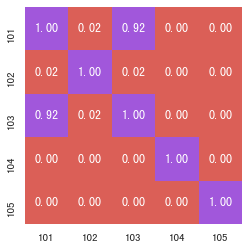

In [38]:

import seaborn as sns
import scikit_posthocs as sp

# 定义颜色映射
cmap = sns.color_palette("hls", 4)

# 执行Dunn检验
results = sp.posthoc_dunn(df, val_col='ord_qty', group_col='sales_region_code')

# 绘制Dunn检验的可视化图
sns.heatmap(results, cmap=cmap, annot=True, fmt=".2f", cbar=False, square=True)


<AxesSubplot: >

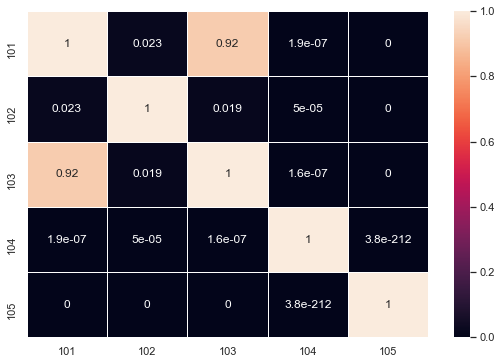

In [39]:
sns.set_theme()

# Load the example flights dataset and convert to long-form

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(results, annot=True, linewidths=.5, ax=ax)

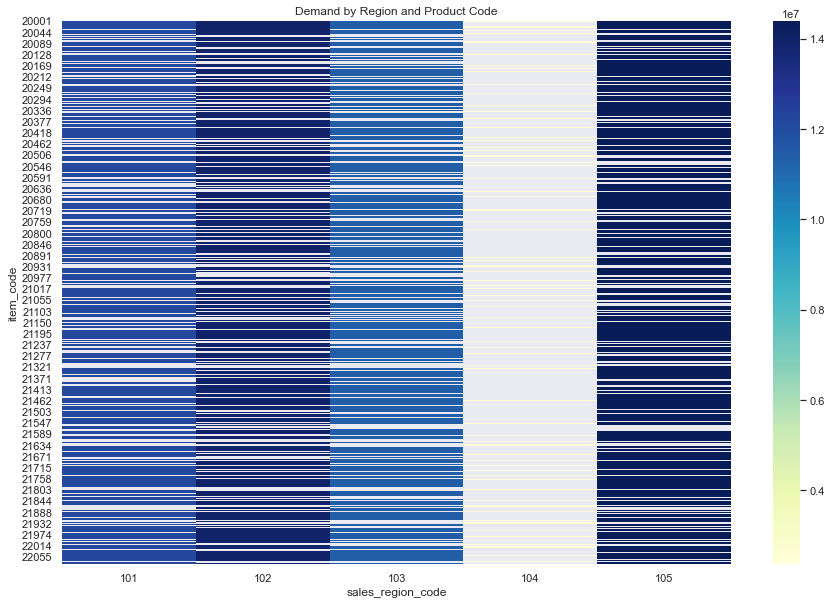

In [40]:
train_df = df
# 统计每个区域的总需求量
region_demand = train_df.groupby('sales_region_code')['ord_qty'].sum().reset_index()

# 将需求量和区域编码合并
region_demand = region_demand.merge(train_df[['sales_region_code', 'item_code']].drop_duplicates(), on='sales_region_code')

# 将区域编码转换为字符串类型
region_demand['sales_region_code'] = region_demand['sales_region_code'].astype(str)

# 将数据透视为区域和产品编码的交叉表
pivot_table = pd.pivot_table(region_demand, values='ord_qty', index='item_code', columns='sales_region_code')

# 绘制热力图
plt.figure(figsize=(15,10))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Demand by Region and Product Code')
plt.show()


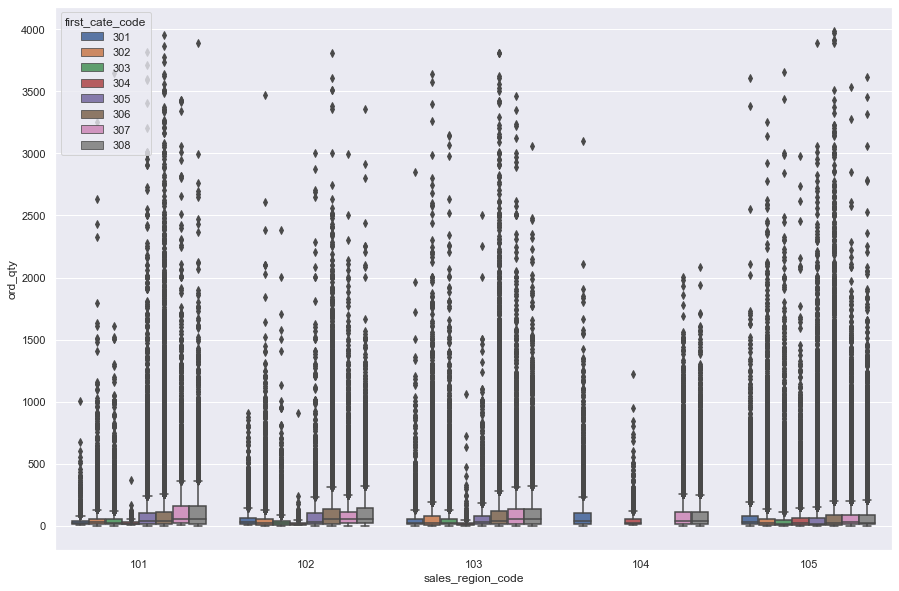

In [41]:

# 绘制每个区域中不同细类产品的需求量分布箱线图
plt.figure(figsize=(15,10))
sns.boxplot(x="sales_region_code", y="ord_qty", hue="first_cate_code", data=train_df)
plt.show()



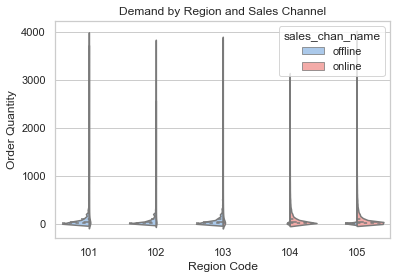

In [42]:
# 不同地区，线上线下的销量

sns.set(style="whitegrid", palette="pastel")

# 绘制小提琴图
ax = sns.violinplot(x="sales_region_code", y="ord_qty", data=train_df, hue="sales_chan_name", split=True, scale="count", inner="quartile", palette={"offline": "b", "online": "r"})

# 设置图形标题和坐标轴标签
ax.set_title("Demand by Region and Sales Channel")
ax.set_xlabel("Region Code")
ax.set_ylabel("Order Quantity")

# 显示图形
plt.show()


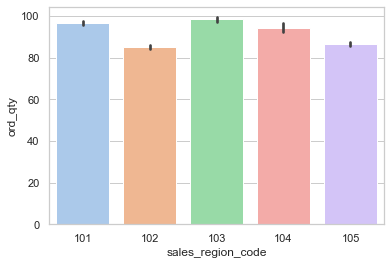

In [43]:
# 绘制销售区域和订单需求量的关系图
sns.barplot(x='sales_region_code', y='ord_qty', data=train_df)
plt.show()


In [44]:
# 计算各区域的订单需求量的平均值、中位数和标准差
grouped_data = train_df.groupby('sales_region_code').agg({'ord_qty': ['mean', 'median', 'std']})
print(grouped_data)

                     ord_qty                   
                        mean median         std
sales_region_code                              
101                96.727715     33  200.928386
102                85.172266     33  152.484841
103                98.391720     32  199.806136
104                94.319274     34  167.733339
105                86.449640     21  196.412573


105    166589
102    163811
101    125872
103    116190
104     25060
Name: sales_region_code, dtype: int64
sales_region_code
101    12175311
102    13952154
103    11432134
104     2363641
105    14401559
Name: ord_qty, dtype: int64


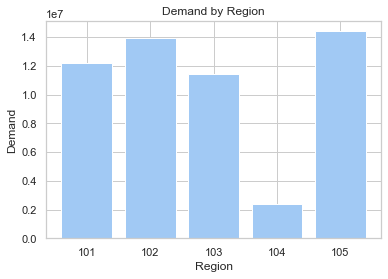

In [45]:
# 用value_counts()函数查看每个区域的产品数量和需求量：
# 每个区域的产品数量和需求量的分布较为对应，102 105最多，101 103中等，104最少
region_counts = train_df['sales_region_code'].value_counts()
demand_counts = train_df.groupby('sales_region_code')['ord_qty'].sum()
print(region_counts)
print(demand_counts)
# 我们可以用柱状图将每个区域的需求量进行可视化
plt.bar(demand_counts.index, demand_counts.values)
plt.title('Demand by Region')
plt.xlabel('Region')
plt.ylabel('Demand')
plt.show()


    sales_region_code  second_cate_code  ord_qty
0                 101               401   938727
1                 101               402   570275
2                 101               403  1070159
3                 101               404  1150116
4                 101               405    51961
5                 101               406     4301
6                 101               407  5580775
7                 101               408   765073
8                 101               409    10341
9                 101               410    24679
10                101               411     5246
11                101               412  2003658
12                102               401   836915
13                102               402   260019
14                102               403  1145520
15                102               404  1364045
16                102               405   223807
17                102               406     5035
18                102               407  6978799
19                10

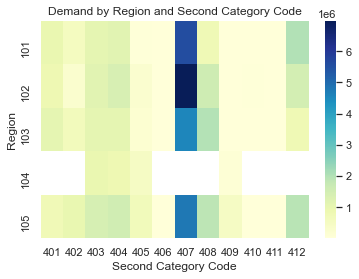

In [46]:
# 再进一步探索每个区域内不同类别产品的需求量分布。我们可以先用groupby()函数按照区域和二级分类对数据进行分组，然后计算每个组的需求量总和
grouped_data = data.groupby(['sales_region_code', 'second_cate_code'])['ord_qty'].sum().reset_index()
print(grouped_data)
# 绘制热力图
pivot_data = grouped_data.pivot(index='sales_region_code', columns='second_cate_code', values='ord_qty')
sns.heatmap(pivot_data, cmap='YlGnBu')
plt.title('Demand by Region and Second Category Code')
plt.xlabel('Second Category Code')
plt.ylabel('Region')
plt.show()
# 要美化的话，需要对需求量的分级进行调整

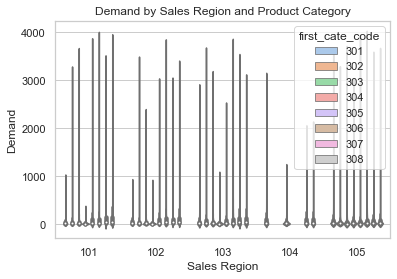

In [47]:
# 还是同上的研究内容，绘制小提琴图

# # 筛选出需要的特征
# df_subset = train_df[['sales_region_code', 'first_cate_code', 'ord_qty']]

# # 按照产品大类编码和销售区域进行分组，并计算需求量的均值
# df_grouped = df_subset.groupby(['first_cate_code', 'sales_region_code']).mean().reset_index()

# 绘制小提琴图
sns.violinplot(x='sales_region_code', y='ord_qty', hue='first_cate_code', data=train_df)
plt.title('Demand by Sales Region and Product Category')
plt.xlabel('Sales Region')
plt.ylabel('Demand')
plt.show()


不同销售方式（线上和线下）的产品需求量的特性

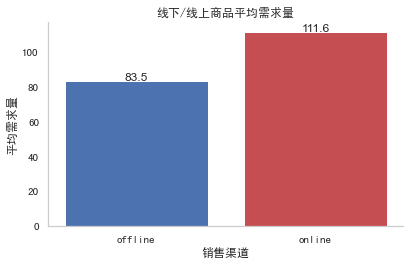

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# 按照销售方式进行分组，并计算每个组别的平均订单需求量
df_sales = train_df.groupby(['sales_chan_name'])['ord_qty'].mean().reset_index()

# 设置颜色和字体
colors = ['#4C72B0', '#C44E52']
font = {'family': 'Arial', 'size': 12}

# 创建图形和坐标轴对象
fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.sans-serif'] = ['SimHei']

# 绘制柱状图
ax.bar(df_sales['sales_chan_name'], df_sales['ord_qty'], color=colors)

# 添加注释和标签
ax.set_title('线下/线上商品平均需求量')
ax.set_xlabel('销售渠道')
ax.set_ylabel('平均需求量')

# # 设置坐标轴的刻度和标签字体
# plt.xticks(fontfamily='Arial', fontsize=10)
# plt.yticks(fontfamily='Arial', fontsize=10)

# 删除上边界和右边界
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# 在柱状图上标出数字
for i, v in enumerate(df_sales['ord_qty']):
    ax.text(i, v+0.1, f'{v:.1f}', fontdict=font, ha='center')

# 调整图形的边距和布局
plt.tight_layout(pad=1.5)
plt.grid(False)
# 显示图形
plt.savefig("./图片/线下上商品平均销量.png",dpi=200)


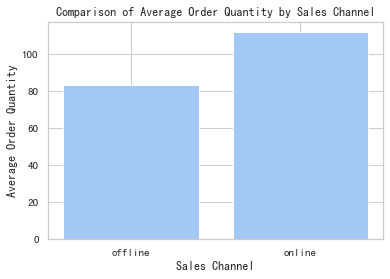

In [49]:
# 按照销售方式进行分组，并计算每个组别的平均订单需求量
df_sales = train_df.groupby(['sales_chan_name'])['ord_qty'].mean().reset_index()
# 我们可以绘制一个柱状图，用于比较线上和线下销售渠道的平均订单需求量
plt.bar(df_sales['sales_chan_name'], df_sales['ord_qty'])
plt.title('Comparison of Average Order Quantity by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Average Order Quantity')
plt.show()

In [50]:
# df_sales 

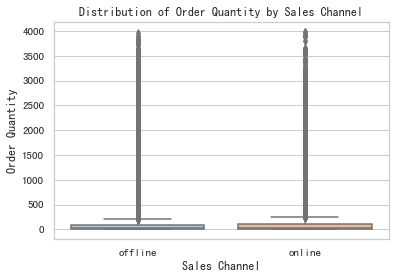

In [51]:
# 我们可使用箱线图，以便于观察销售方式的需求量分布情况

sns.boxplot(x='sales_chan_name', y='ord_qty', data=train_df)
plt.title('Distribution of Order Quantity by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Order Quantity')
plt.show()


不同品类之间的产品需求量有何不同点和共同点

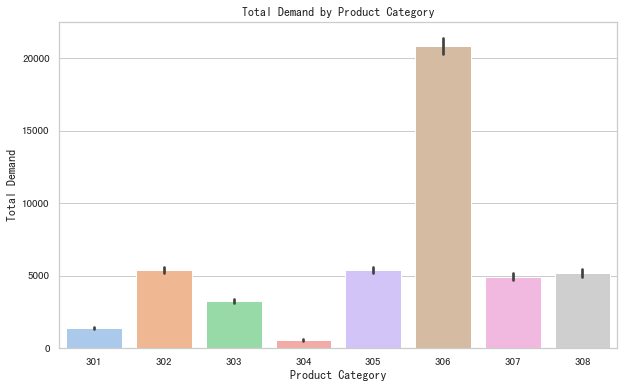

In [52]:

# 加载数据文件
data = train_df


# 计算每个“产品大类编码”和“订单日期”的总需求量
demand_by_category = data.groupby(['first_cate_code', 'order_date'])['ord_qty'].sum().reset_index()

# 绘制不同产品大类之间总需求量的条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='first_cate_code', y='ord_qty', data=demand_by_category)
plt.title('Total Demand by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Demand')
plt.show()




In [53]:
df_subcate/sum(df_subcate["ord_qty"])

NameError: name 'df_subcate' is not defined

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 统计不同大类商品的需求量
df_cate = data.groupby('first_cate_code')['ord_qty'].sum().reset_index()

# 统计不同小类商品的需求量
df_subcate = data.groupby('second_cate_code')['ord_qty'].sum().reset_index()

# 设置图形大小和字体
plt.figure(figsize=(10, 5))
plt.rcParams['font.sans-serif'] = ['SimHei']

# 绘制不同大类商品的需求分布图
plt.subplot(1, 2, 1)
plt.bar(df_cate['first_cate_code'], df_cate['ord_qty'])
plt.title('不同大类商品的总销量')
plt.xlabel('商品大类')
plt.ylabel('需求量')
plt.grid(False)

# 绘制不同小类商品的需求分布图
plt.subplot(1, 2, 2)
plt.bar(df_subcate['second_cate_code'], df_subcate['ord_qty'])
plt.title('不同小类商品的总销量')
plt.xlabel('商品细类')
plt.ylabel('需求量')
plt.grid(False)
# 调整布局并显示图像
plt.tight_layout()
# plt.show()
plt.savefig("./图片/各大类商品总销量.png",dpi=200)

In [ ]:
data["商品类别"] = data["first_cate_code"]
# 绘制大类商品销量分布图
fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(data=data, x="ord_qty", hue="商品类别", fill=True, alpha=0.5, linewidth=0.1, ax=ax)

# 设置图形属性
ax.set_title("各大类商品销量分布图", fontsize=18)
ax.set_xlabel("销量", fontsize=14)
ax.set_ylabel("密度", fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xlim([0,1500])
# ax.legend(fontsize=12, title="Category", title_fontsize=14)

# plt.show()
plt.savefig("./图片/各大类商品销量分布图.png",dpi=200)

In [ ]:
# 设置颜色列表
colors = sns.color_palette("Set1", n_colors=len(data["first_cate_code"].unique()))

# 创建画布
fig, ax = plt.subplots(figsize=(12, 6))

# 遍历每个first_cate_code并绘制对应的概率密度图
for i, category in enumerate([301, 302, 303,304, 305,306,307,308]):
    sns.kdeplot(data=data[data["first_cate_code"] == category], x="ord_qty",
                fill=True, alpha=0.5, linewidth=1, ax=ax, color=colors[i], label=category, clip=[0,None])

# 设置图形属性
ax.set_title("各大类商品销量分布图", fontsize=18)
ax.set_xlabel("销量", fontsize=14)
ax.set_xlim(0, 600)
ax.set_ylabel("密度", fontsize=14)
ax.tick_params(labelsize=12)
ax.legend(fontsize=14, title="商品类别", title_fontsize=14)
ax.yaxis.set_visible(False)
ax.grid(False)

In [ ]:

# 设置颜色列表
colors = sns.color_palette("Set2", n_colors=len(data["second_cate_code"].unique()))

# 创建画布
fig, ax = plt.subplots(figsize=(20, 6))
plt.rcParams['font.sans-serif'] = ['SimHei']

# 遍历每个first_cate_code并绘制对应的概率密度图
for i, category in enumerate([401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412]):
    sns.kdeplot(data=data[data["second_cate_code"] == category], x="ord_qty",
                fill=True, alpha=0.5, linewidth=1, ax=ax, color=colors[i], label=category, clip=[0,None])

# 设置图形属性
ax.set_title("各小类商品销量分布图", fontsize=18)
ax.set_xlabel("销量", fontsize=14)
ax.set_xlim(0, 300)
ax.set_ylabel("密度", fontsize=14)
ax.tick_params(labelsize=12)
ax.legend(fontsize=14, title="商品类别", title_fontsize=14)
ax.yaxis.set_visible(False)
# ax.grid(False)
# plt.savefig("./图片/各小类商品销量分布图.png",dpi=200)

In [ ]:
len(data[data["ord_qty"] < 0])

不同时间段（例如月头、月中、月末等）产品需求量有何特性；

In [55]:
df = sales_data

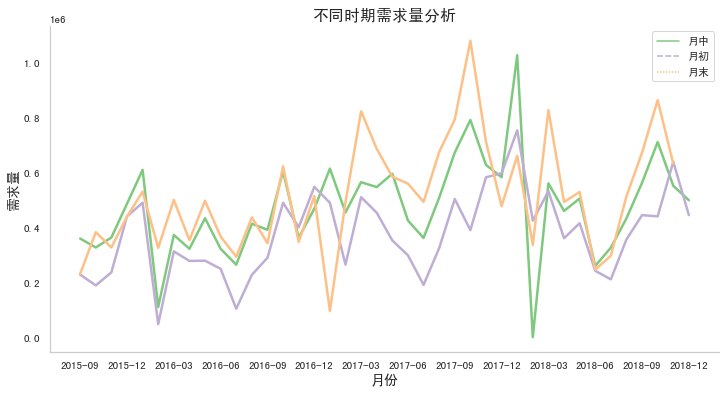

In [56]:
from matplotlib import ticker # 导入ticker模块

df['day_of_month'] = df['order_date'].dt.day
df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
df['时间段'] = np.where(df['day_of_month'] <= 10, '月初',
                        np.where(df['day_of_month'] > 20, '月末', '月中'))

grouped = df.groupby(['year_month', '时间段'])['ord_qty'].sum().reset_index()
pivot_table = grouped.pivot(index='year_month', columns='时间段', values='ord_qty')

# 设置背景风格和颜色
sns.set(style="whitegrid", palette=sns.color_palette('Accent', n_colors=3))

# 绘制图表
plt.figure(figsize=(12, 6))  # 设置画布大小
plt.rcParams['font.sans-serif'] = ['SimHei']

ax = sns.lineplot(data=pivot_table, linewidth=2.5)  # 绘制线条

ax.lines[0].set_linestyle("-")
ax.lines[1].set_linestyle("-")
ax.lines[2].set_linestyle("-")
ax.legend()


# 设置坐标轴标签和标题
ax.set_xlabel('月份', fontsize=14)
ax.set_ylabel('需求量', fontsize=14)
ax.set_title('不同时期需求量分析', fontsize=16)

# 设置x轴刻度间隔
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

# 去除网格和边框
ax.grid(False)
sns.despine()

# plt.show()
plt.savefig('./图片/不同时间段需求量分析.svg', dpi=300)


# 节假日

In [79]:

def is_holiday_and_weekend(date):
    """
    判断日期是否为节假日且不为周末
    """
    is_holiday = calendar.is_holiday(date)
    is_weekend = (date.weekday() == 5) or (date.weekday() == 6)  # 判断是否为周末
    return is_holiday and (not is_weekend)

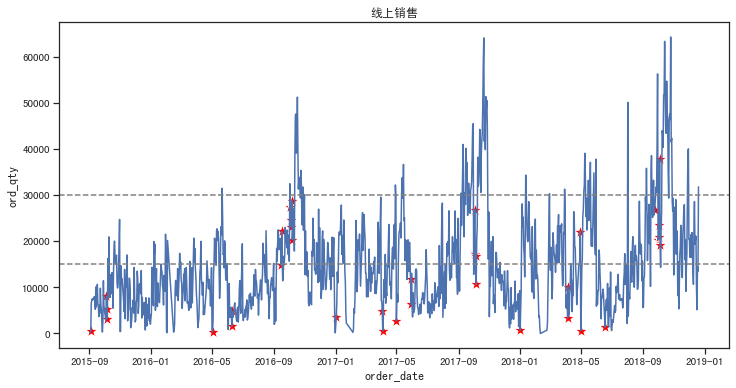

In [114]:

import chinese_calendar as calendar
sns.set(style="ticks")
plt.rcParams['font.sans-serif'] = ['SimHei']

# 按线上线下拆分数据
df_online = df[df['sales_chan_name'] == 'online']
df_offline = df[df['sales_chan_name'] == 'offline']

# 统计每一天的所有商品销量
df_online_daily_sales = df_online.groupby('order_date')['ord_qty'].sum().reset_index()
df_offline_daily_sales = df_offline.groupby('order_date')['ord_qty'].sum().reset_index()

# 添加是否为节假日的标记
df_online_daily_sales['is_holiday'] = df_online_daily_sales['order_date'].apply(lambda x: is_holiday_and_weekend(x))
df_offline_daily_sales['is_holiday'] = df_offline_daily_sales['order_date'].apply(lambda x: is_holiday_and_weekend(x))

# 设置图形参数
plt.figure(figsize=(12, 6))
plt.title('线上销售')

# 绘制节假日散点图
sns.scatterplot(x='order_date', y='ord_qty', data=df_online_daily_sales[df_online_daily_sales['is_holiday']],
                color='red', marker='*', s=200)

# 绘制线上每日销量的折线图
sns.lineplot(x='order_date', y='ord_qty', data=df_online_daily_sales)



# 添加一条横线
plt.axhline(y=15000, color='grey', linestyle='--')
plt.axhline(y=30000, color='grey', linestyle='--')

# plt.show()
plt.savefig('./图片/节假日线上.png', dpi=300)



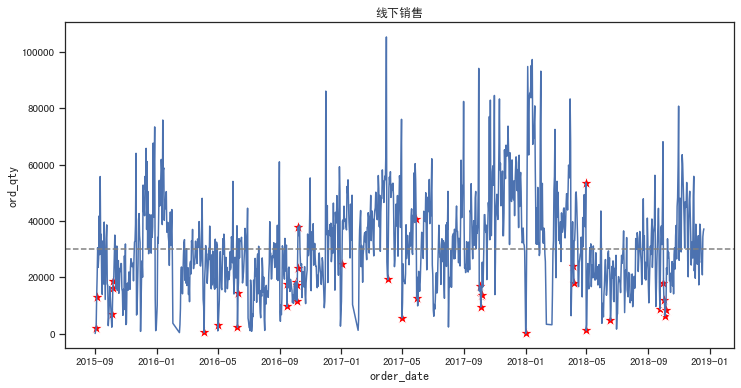

In [117]:
sns.set(style="ticks")
plt.rcParams['font.sans-serif'] = ['SimHei']

# 设置图形参数
plt.figure(figsize=(12, 6))
plt.title('线下销售')


# 绘制线下每日销量的折线图
sns.lineplot(x='order_date', y='ord_qty', data=df_offline_daily_sales)


# # 添加一条横线
# plt.axhline(y=10000, color='black', linestyle='--')

# 绘制节假日散点图
sns.scatterplot(x='order_date', y='ord_qty', data=df_offline_daily_sales[df_offline_daily_sales['is_holiday']],
                color='red', marker='*', s=200)

plt.axhline(y=30000, color='grey', linestyle='--')

plt.savefig('./图片/节假日线下.png', dpi=300)


In [81]:
# df_online_daily_sales[df_online_daily_sales['is_holiday']]

order_date  ord_qty  is_holiday
1    2015-09-04      610        True
29   2015-10-05     8032        True
30   2015-10-06     3253        True
31   2015-10-07     5361        True
226  2016-05-02      356        True
264  2016-06-09     1554        True
265  2016-06-10     4781        True
362  2016-09-15    14852        True
363  2016-09-16    22230        True
380  2016-10-03    27415        True
381  2016-10-04    24580        True
382  2016-10-05    23195        True
383  2016-10-06    28859        True
384  2016-10-07    20384        True
470  2017-01-02     3622        True
549  2017-04-03     4891        True
550  2017-04-04      595        True
577  2017-05-01     2714        True
605  2017-05-29    11726        True
606  2017-05-30     6303        True
731  2017-10-02    17458        True
732  2017-10-03    26899        True
733  2017-10-04    17282        True
734  2017-10-05    16729        True
735  2017-10-06    10653        True
822  2018-01-01      696        True
904  2018-04-05     3354        True
905  2018-04-06    10082        True
929  2018-04-30    22137        True
930  2018-05-01      603        True
978  2018-06-18     1365        True
1076 2018-09-24    26912        True
1083 2018-10-01    20360        True
1084 2018-10-02    21008        True
1085 2018-10-03    23625        True
1086 2018-10-04    37817        True
1087 2018-10-05    19128        True